In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import getcwd
import warnings
warnings.filterwarnings("ignore")
from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.all import ExponentialSmoothing
from sktime.forecasting.all import ForecastingHorizon
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display_html
from sklearn.ensemble import RandomForestClassifier
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error


# os.chdir('/Users/maneetsingh/Documents/University of Chicago/Financial Mathematics/4. Spring Quarter/Time Series/ts_forex_project')

### Data Pre-Processing

In [63]:
import quandl
import wrds
import functools
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_securities):
        print("Fetching from Quandl")
        qdata = quandl.get(list(my_securities), returns="pandas",
                          api_key="ZNndJ3C7Y1SBCtdKn-MP",
                          start_date='2000-01-01', end_date='2019-12-31')
        return qdata
    print("fetch_quandl has now been newly defined")
    
    
    
def stationarity_test(data):
    colnames = data.columns
    results = pd.DataFrame()
    for i in colnames:
        dftest = adfuller(data[i])
        dfoutput = pd.Series(dftest[0:3], index= pd.MultiIndex.from_arrays([['ADF Test','ADF Test','ADF Test'],['Test Statistic','p-value','#Lags Used']], names = ('Test', 'Value')))
        for key,value in dftest[4].items():
           dfoutput['ADF Test', 'Critical Value (%s)'%key] = value
        if dftest[1] < 0.05:
            dfoutput['ADF Test', 'Result'] = 'Pass'
        else:
            dfoutput['ADF Test', 'Result'] = 'Fail'
        
        kpsstest = kpss(data[i], regression = 'ct')
        kpssoutput = pd.Series(kpsstest[0:3], index= pd.MultiIndex.from_arrays([['KPSS Test','KPSS Test','KPSS Test'],['Test Statistic','p-value','#Lags Used']], names = ('Test', 'Value')))
        for key,value in kpsstest[3].items():
            if(key != '2.5%'):
                kpssoutput['KPSS Test', 'Critical Value (%s)'%key] = value
        if kpsstest[1] > 0.05:
            kpssoutput['KPSS Test', 'Result'] = 'Pass'
        else:
            kpssoutput['KPSS Test', 'Result'] = 'Fail'

        results = pd.concat([results,pd.concat([pd.DataFrame(dfoutput, columns=[i]), pd.DataFrame(kpssoutput, columns=[i])])], axis = 1)
        
    return results


#define KPSS
def kpss_test(data, alpha, trend='ct'):
#     print ('Results of KPSS Test: '+ label)
    kpss_output = pd.DataFrame(index=['Test Statistic','p-value','#Lags Used','Critical Value (10%)','Critical Value (5%)','Critical Value (2.5%)','Critical Value (1%)','stationarity from KPSS test'],columns = data.columns)
    for i in data.columns:
        kpsstest = kpss(data.loc[:,i], regression=trend)
        kpss_output.loc[0:3,i]= np.array(kpsstest[0:3])
        kpss_output.loc[3:7,i]= np.array(list(kpsstest[3].values()))
        kpss_output.loc['stationarity from KPSS test',i] = kpsstest[1]>=alpha
    return kpss_output

def adf_test(data,alpha):
    #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test: ' + label)
    dfoutput = pd.DataFrame(index=['Test Statistic','p-value','#Lags Used','Number of Observations Used','Critical Value (1%)','Critical Value (5%)','Critical Value (10%)','stationarity from ad_fuller test'],columns = data.columns)
    for i in data.columns:
        dftest = adfuller(data.loc[:,i])
        dfoutput.loc[0:4,i]= np.array(dftest[0:4])
        dfoutput.loc[4:7,i]= np.array(list(dftest[4].values()))
        dfoutput.loc['stationarity from ad_fuller test',i] = dftest[1]<=alpha
    return dfoutput

# define modelevaluatiion matrics
def model_evaluation_metrics(ytrue,y_pred,y_train,label):
    mape = MeanAbsolutePercentageError(symmetric=False)
    smape = MeanAbsolutePercentageError()
    
    metrics = pd.DataFrame(index = ['MAE','MSE','RMSE','MAPE','sMAPE', 'MASE'], columns = [label])
    metrics.iloc[0,0] = round(mean_absolute_error(ytrue, y_pred),5)
    metrics.iloc[1,0] = round(mean_squared_error(ytrue, y_pred),5)
    metrics.iloc[2,0] = round(np.sqrt(mean_squared_error(ytrue, y_pred)),5)
    metrics.iloc[3,0] = round(mape(ytrue, y_pred),5)
    metrics.iloc[4,0] = round(smape(ytrue, y_pred),5)
    metrics.iloc[5,0] = mean_absolute_scaled_error(ytrue, y_pred, y_train = y_train)
    return metrics

def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot(figsize = (15,7))
    y_test.plot()
    y_pred.plot()
    plt.legend(['y_train','y_test','y_pred'])
    plt.show()
    
    
def residuals_analysis(residuals):
    # residual checks
    # scatter plot of residuals
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0][0].scatter(residuals.index,residuals)
    ax[0][0].set_title("Scatter for residuals")
    ax[0][0].set_xlabel("Date")
    ax[0][0].set_ylabel("Residuals")
    # histogram for residuals
    ax[0][1].hist(residuals, bins=20, rwidth=0.9, color='#607c8e', density =True, align='mid',range=[-1, 1])
    ax[0][1].set_title('Histograms and KDE of residuals')
    # ACF and PACF plots
    plot_acf(residuals, lags=40, zero=False, title='residuals ACF Plot', ax =ax[1][0])
    plot_pacf(residuals, lags=40, zero=False, title='residuals PACF Plot', ax =ax[1][1])
    plt.show()

    fig.tight_layout()
    display(sm.stats.acorr_ljungbox(residuals, lags=[1,5,12,24], return_df=True, boxpierce=True))
    # summary stats of residuals
    display(residuals.describe())
    dw(residuals)
    test_shapiro_wilk(residuals, alpha=0.05)
#     test_breuschpagan(residuals, y_train.iloc[13:,1], alpha=0.05)

fetch_quandl already defined


In [4]:
rates = fetch_quandl(tuple(['YC/USA5Y','YC/FRA5Y','YC/NZL5Y','YC/GBR5Y','YC/CAN5Y','YC/JPN5Y'])).interpolate().dropna()
#rates = rates.resample('M').last()

# Read Data from CSV
forex_data = pd.read_csv('../data/Foreign_Exchange_Rates.csv', na_values='ND')

#Column Cleanup
extracted_columns = ['Time Serie', 'EURO AREA - EURO/US$', 'NEW ZEALAND - NEW ZELAND DOLLAR/US$', 'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'CANADA - CANADIAN DOLLAR/US$', 'JAPAN - YEN/US$']
named_columns = ['date', 'EURUSD', 'NZDUSD', 'GBPUSD', 'CADUSD', 'JPYUSD']
forex_data = forex_data[extracted_columns]
forex_data.columns = named_columns

# Set Date as Index
forex_data = forex_data.set_index('date')
forex_data.index = pd.to_datetime(forex_data.index) 

#Keep Only Business Days
forex_data = forex_data.interpolate().loc[rates.index.min():]

#Resample Data to Monthly
#forex_data = forex_data.resample('M').last()

#Display Sample
display(forex_data)

Fetching from Quandl


,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD
date,,,,,
2004-08-20,0.81140,1.4859,0.54910,1.2980,109.320
2004-08-23,0.81990,1.4981,0.55120,1.3065,109.470
2004-08-24,0.82650,1.5328,0.55760,1.3048,109.630
2004-08-25,0.82710,1.5354,0.55660,1.3047,110.380
2004-08-26,0.82750,1.5411,0.55740,1.3123,109.730
...,...,...,...,...,...
2019-12-25,0.90145,1.5030,0.77035,1.3142,109.525
2019-12-26,0.90070,1.5002,0.76880,1.3124,109.670
2019-12-27,0.89490,1.4919,0.76390,1.3073,109.470


### Data Summary

,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD
# of Non-Missing Observations,"4,008.00","4,008.00","4,008.00","4,008.00","4,008.00"
Mean,0.79,1.39,0.64,1.16,103.63
Median,0.78,1.40,0.63,1.15,107.18
Minimum Value,0.62,1.13,0.47,0.92,75.72
Maximum Value,0.96,2.03,0.83,1.46,125.58


 
                                            EDA for FOREX Data                                               
 


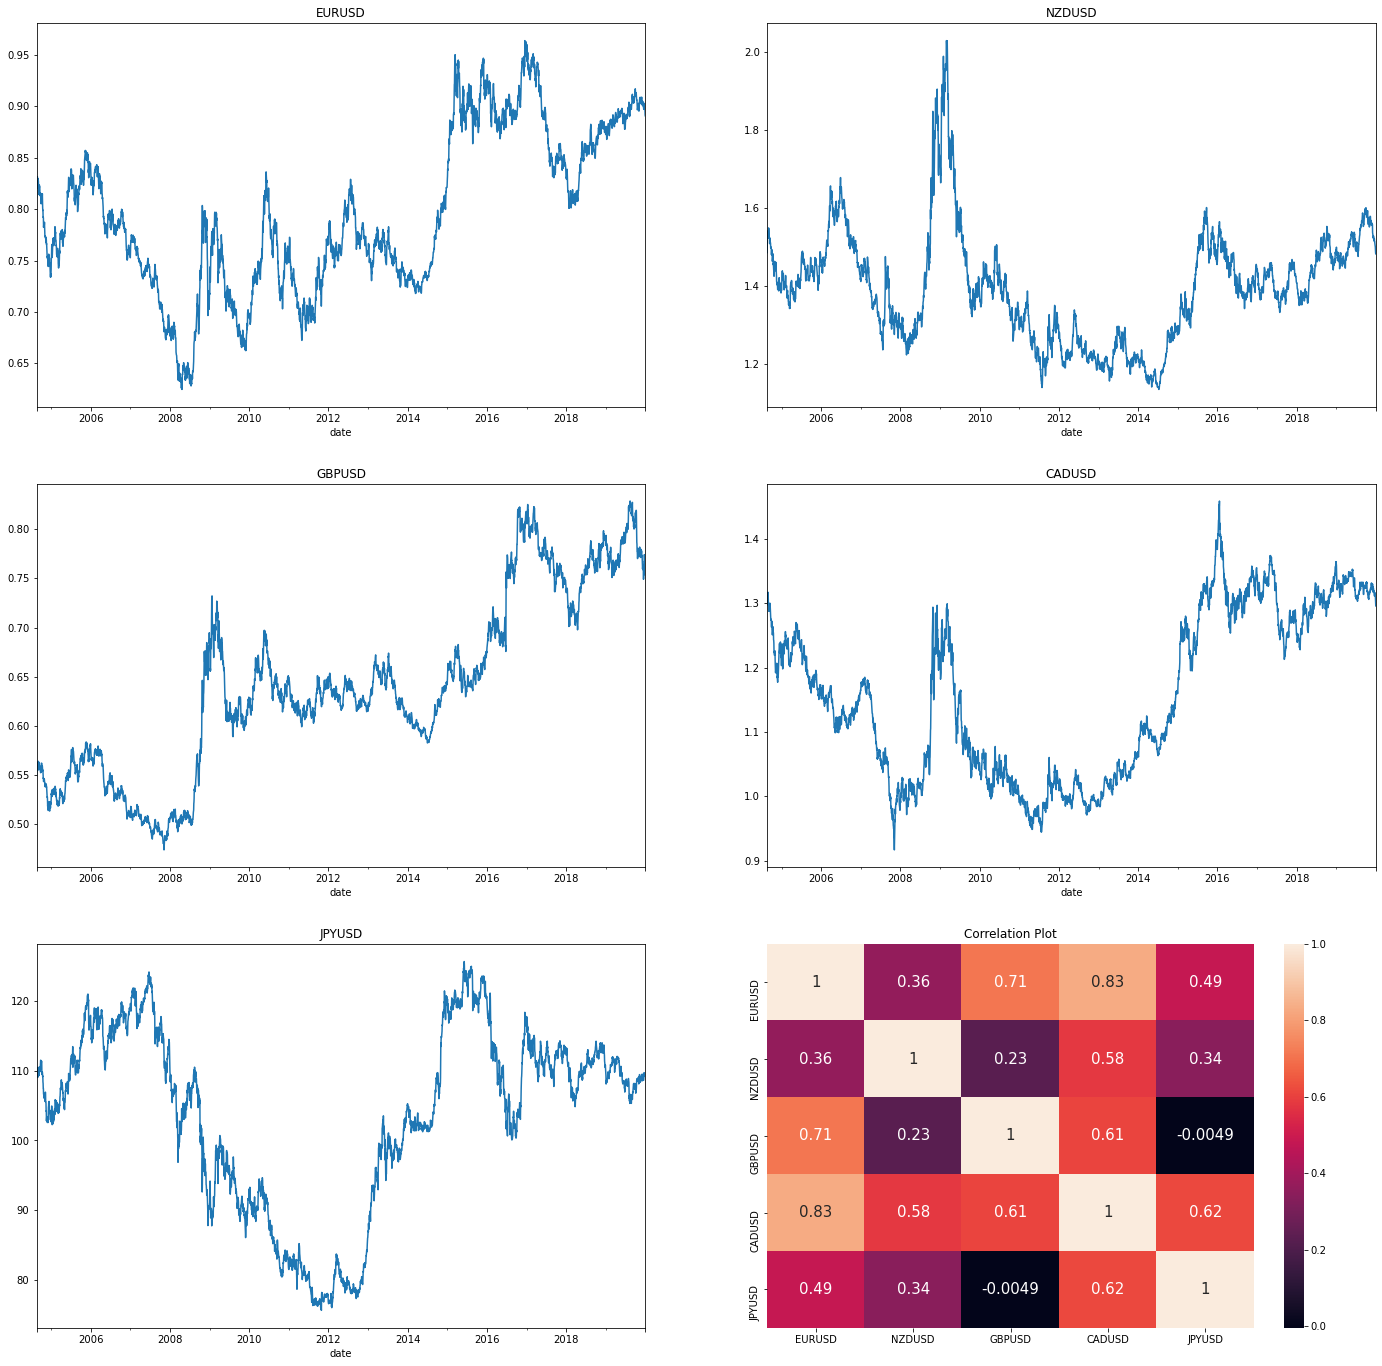

 
                                            EDA for FOREX Data (First Difference)                                              
 


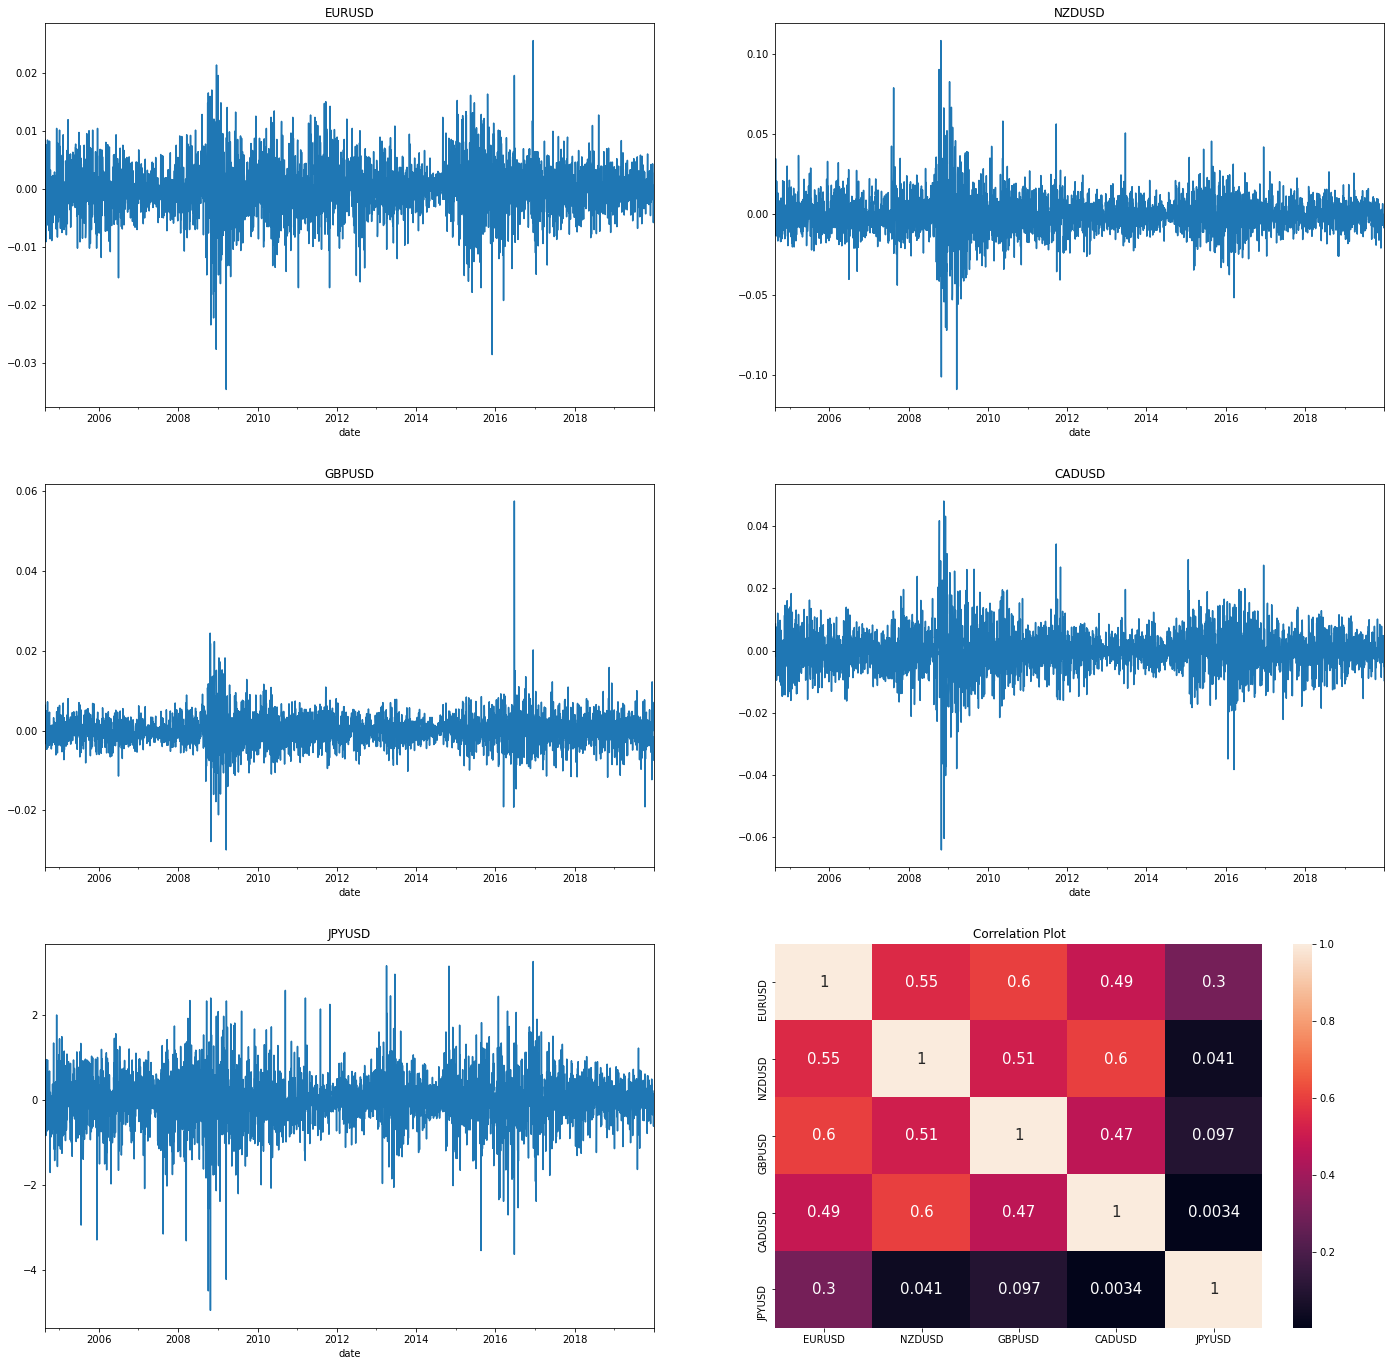

EURUSD    NZDUSD    GBPUSD    CADUSD  \
Test      Value                                                          
ADF Test  Test Statistic       -1.640518 -2.589973 -1.089545 -1.567261   
          p-value                0.46199  0.095087  0.719223  0.500015   
          #Lags Used                 0.0       6.0      27.0       9.0   
          Critical Value (1%)  -3.431983 -3.431985 -3.431994 -3.431987   
          Critical Value (5%)  -2.862262 -2.862263 -2.862266 -2.862263   
          Critical Value (10%) -2.567154 -2.567155 -2.567157 -2.567155   
          Result                    Fail      Fail      Fail      Fail   
KPSS Test Test Statistic        1.117617    0.9237   0.43235  1.740687   
          p-value                   0.01      0.01      0.01      0.01   
          #Lags Used                39.0      39.0      39.0      39.0   
          Critical Value (10%)     0.119     0.119     0.119     0.119   
          Critical Value (5%)      0.146     0.146     0.146     0.146   
          Critical Value (1%)      0.216     0.216     0.216     0.216   
          Result                    Fail      Fail      Fail      Fail   

                                  JPYUSD  
Test      Value                           
ADF Test  Test Statistic       -1.490891  
          p-value               0.538013  
          #Lags Used                26.0  
          Critical Value (1%)  -3.431994  
          Critical Value (5%)  -2.862266  
          Critical Value (10%) -2.567157  
          Result                    Fail  
KPSS Test Test Statistic        1.601834  
          p-value                   0.01  
          #Lags Used                39.0  
          Critical Value (10%)     0.119  
          Critical Value (5%)      0.146  
          Critical Value (1%)      0.216  
          Result                    Fail

EURUSD     NZDUSD     GBPUSD     CADUSD  \
Test      Value                                                              
ADF Test  Test Statistic       -61.999424 -27.265668 -13.087091 -22.237808   
          p-value                     0.0        0.0        0.0        0.0   
          #Lags Used                  0.0        5.0       26.0        8.0   
          Critical Value (1%)   -3.431983  -3.431985  -3.431994  -3.431987   
          Critical Value (5%)   -2.862262  -2.862263  -2.862266  -2.862263   
          Critical Value (10%)  -2.567154  -2.567155  -2.567157  -2.567155   
          Result                     Pass       Pass       Pass       Pass   
KPSS Test Test Statistic         0.040134   0.030618   0.037673   0.060291   
          p-value                     0.1        0.1        0.1        0.1   
          #Lags Used                  4.0       14.0        9.0       13.0   
          Critical Value (10%)      0.119      0.119      0.119      0.119   
          Critical Value (5%)       0.146      0.146      0.146      0.146   
          Critical Value (1%)       0.216      0.216      0.216      0.216   
          Result                     Pass       Pass       Pass       Pass   

                                   JPYUSD  
Test      Value                            
ADF Test  Test Statistic       -12.396941  
          p-value                     0.0  
          #Lags Used                 25.0  
          Critical Value (1%)   -3.431994  
          Critical Value (5%)   -2.862266  
          Critical Value (10%)  -2.567157  
          Result                     Pass  
KPSS Test Test Statistic         0.096301  
          p-value                     0.1  
          #Lags Used                 10.0  
          Critical Value (10%)      0.119  
          Critical Value (5%)       0.146  
          Critical Value (1%)       0.216  
          Result                     Pass

In [41]:
pa_summary = forex_data.describe()
pa_summary = pa_summary.loc[['count', 'mean', '50%', 'min', 'max']]
pa_summary.index = ['# of Non-Missing Observations', 'Mean', 'Median', 'Minimum Value', 'Maximum Value']

# Data Summary Table
display(pa_summary.style.format('{:,.2f}'))

print(" ")
print("=============================================================================================================")
print("                                            EDA for FOREX Data                                               ")
print("=============================================================================================================")
print(" ")


# Data Plots
rows = 3
cols = 2
idx = 0
fig, ax = plt.subplots(rows, cols, figsize = (24,24))

for i in range(rows):
    for j in range(cols):
        if (i == 2) & (j == 1): 
            sns.heatmap(forex_data.corr(), annot=True, annot_kws={'size': 15})
            ax[i][j].set_title('Correlation Plot')
        else:
            forex_data.iloc[:,idx].plot(ax = ax[i][j])
            ax[i][j].set_title(forex_data.iloc[:,idx].name)
            idx += 1
            
plt.show()

print(" ")
print("=============================================================================================================")
print("                                        EDA for FOREX Data (First Difference)                                ")
print("=============================================================================================================")
print(" ")


# Difference Data
rows = 3
cols = 2
idx = 0
fig, ax = plt.subplots(rows, cols, figsize = (24,24))

for i in range(rows):
    for j in range(cols):
        if (i == 2) & (j == 1): 
            sns.heatmap(forex_data.diff().dropna().corr(), annot=True, annot_kws={'size': 15})
            ax[i][j].set_title('Correlation Plot')
        else:
            forex_data.diff().dropna().iloc[:,idx].plot(ax = ax[i][j])
            ax[i][j].set_title(forex_data.diff().dropna().iloc[:,idx].name)
            idx += 1
            
plt.show()


display(stationarity_test(forex_data.dropna()))
display(stationarity_test(forex_data.diff().dropna()))

In [70]:
data = forex_data.merge(rates,left_index=True, right_index=True)

pa_summary = data.describe()
pa_summary = pa_summary.loc[['count', 'mean', '50%', 'min', 'max']]
pa_summary.index = ['# of Non-Missing Observations', 'Mean', 'Median', 'Minimum Value', 'Maximum Value']

# Data Summary Table
display(pa_summary.style.format('{:,.2f}'))

,EURUSD,NZDUSD,GBPUSD,CADUSD,JPYUSD,YC/USA5Y - Rate,YC/FRA5Y - Rate,YC/NZL5Y - Rate,YC/GBR5Y - Yield,YC/CAN5Y - Rate,YC/JPN5Y - Yield
# of Non-Missing Observations,"3,998.00","3,998.00","3,998.00","3,998.00","3,998.00","3,998.00","3,998.00","3,998.00","3,998.00","3,998.00","3,998.00"
Mean,0.79,1.39,0.64,1.16,103.63,2.34,0.42,4.08,2.30,2.24,0.39
Median,0.78,1.40,0.63,1.15,107.16,1.93,0.60,4.01,1.76,1.94,0.30
Minimum Value,0.62,1.13,0.47,0.92,75.72,0.56,-0.80,0.76,0.15,0.48,-0.39
Maximum Value,0.96,2.03,0.83,1.46,125.58,5.23,1.51,7.42,5.80,4.75,1.57


In [71]:
data_gbp = data[['GBPUSD']]
data_gbp['spread'] = (data['YC/GBR5Y - Yield'])/(data['YC/USA5Y - Rate'])


data_eur = data[['EURUSD']]
data_eur['spread'] = (data['YC/FRA5Y - Rate'])/(data['YC/USA5Y - Rate'])


data_cad = data[['CADUSD']]
data_cad['spread'] = (data['YC/CAN5Y - Rate'])/(data['YC/USA5Y - Rate'])


data_nzd = data[['NZDUSD']]
data_nzd['spread'] = (data['YC/NZL5Y - Rate'])/(data['YC/USA5Y - Rate'])


data_jpy = data[['JPYUSD']]
data_jpy['spread'] = (data['YC/JPN5Y - Yield'])/(data['YC/USA5Y - Rate'])

In [61]:
data_var = forex_data.copy()

data_var['gbp_spread'] = (data['YC/GBR5Y - Yield'])/(data['YC/USA5Y - Rate'])
data_var['eur_spread'] = (data['YC/FRA5Y - Rate'])/(data['YC/USA5Y - Rate'])
data_var['cad_spread'] = (data['YC/CAN5Y - Rate'])/(data['YC/USA5Y - Rate'])
data_var['nzd_spread'] = (data['YC/NZL5Y - Rate'])/(data['YC/USA5Y - Rate'])
data_var['jpy_spread'] = (data['YC/JPN5Y - Yield'])/(data['YC/USA5Y - Rate'])

data_var.to_csv('data_varma.csv')

### GBP

 
                                                   GBP                                                       
 
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  138
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 12)   Log Likelihood                 335.340
Date:                              Fri, 03 Jun 2022   AIC                           -652.680
Time:                                      20:10:47   BIC                           -627.226
Sample:                                           0   HQIC                          -642.339
                                              - 138                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

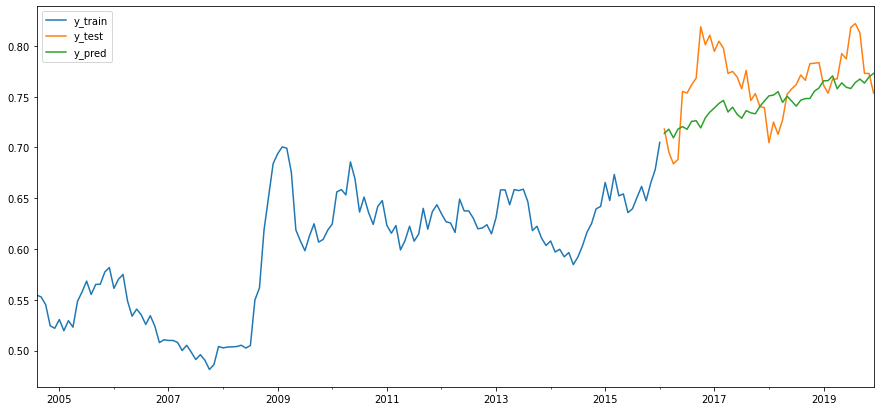

,GBP - Auto ARIMA
MAE,0.03071
MSE,0.00139
RMSE,0.03732
MAPE,0.03968
sMAPE,0.04053
MASE,2.562857


 
                                                   EUR                                                       
 
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  138
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 272.440
Date:                            Fri, 03 Jun 2022   AIC                           -536.880
Time:                                    20:11:15   BIC                           -525.567
Sample:                                         0   HQIC                          -532.284
                                            - 138                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


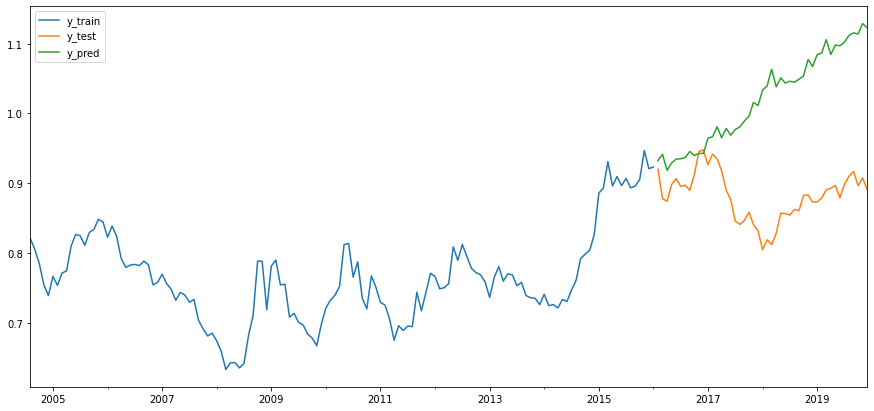

,EUR - Auto ARIMA
MAE,0.13897
MSE,0.02554
RMSE,0.15981
MAPE,0.15993
sMAPE,0.14465
MASE,8.020268


 
                                                   NZD                                                       
 
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  138
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 152.398
Date:                            Fri, 03 Jun 2022   AIC                           -296.796
Time:                                    20:11:36   BIC                           -285.483
Sample:                                         0   HQIC                          -292.200
                                            - 138                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


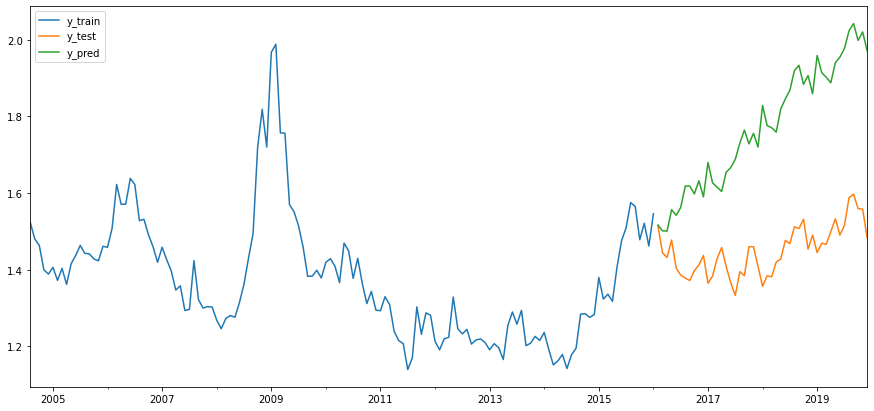

,NZD - Auto ARIMA
MAE,0.32145
MSE,0.11985
RMSE,0.34619
MAPE,0.22114
sMAPE,0.19634
MASE,7.320998


 
                                                   CAD                                                       
 
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  138
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 239.048
Date:                              Fri, 03 Jun 2022   AIC                           -472.096
Time:                                      20:12:02   BIC                           -463.611
Sample:                                           0   HQIC                          -468.649
                                              - 138                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

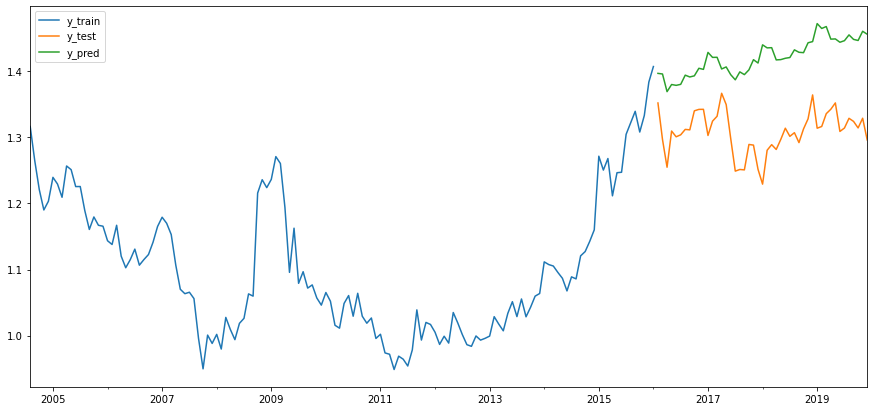

,CAD - Auto ARIMA
MAE,0.11297
MSE,0.01401
RMSE,0.11838
MAPE,0.08683
sMAPE,0.08286
MASE,4.655425


 
                                                   JPY                                                       
 
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  138
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -315.336
Date:                              Fri, 03 Jun 2022   AIC                            636.672
Time:                                      20:12:58   BIC                            645.157
Sample:                                           0   HQIC                           640.119
                                              - 138                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

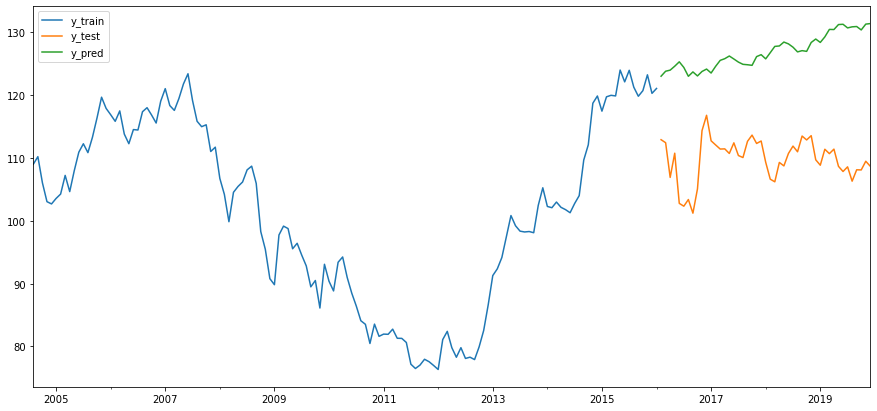

,JPY - Auto ARIMA
MAE,17.03054
MSE,308.67277
RMSE,17.56909
MAPE,0.15612
sMAPE,0.14408
MASE,8.096837


In [72]:
print(" ")
print("=============================================================================================================")
print("                                                   GBP                                                       ")
print("=============================================================================================================")
print(" ")



# model fitting
y_train, y_test = temporal_train_test_split(data_gbp.resample('M').last())
autoarima_model = pm.auto_arima(y_train.iloc[:,0],exogenous =np.array(y_train.iloc[:,1]).reshape(-1,1),d=1, D=1, m=12, seasonality= True)
print(autoarima_model.summary())


# model prediction
y_pred_autoarima = autoarima_model.predict(n_periods = len(y_test),exogenous=np.array(y_test.iloc[:,1]).reshape(-1,1))
y_pred_autoarima = pd.Series(y_pred_autoarima,index =y_test.index)
plot_results(y_train.iloc[:,0],y_test.iloc[:,0],y_pred_autoarima)

autoarima_stat = model_evaluation_metrics(y_test.iloc[:,0],y_pred_autoarima,y_train.iloc[:,0],'GBP - Auto ARIMA')
display(autoarima_stat)



print(" ")
print("=============================================================================================================")
print("                                                   EUR                                                       ")
print("=============================================================================================================")
print(" ")



# model fitting
y_train, y_test = temporal_train_test_split(data_eur.resample('M').last())
autoarima_model = pm.auto_arima(y_train.iloc[:,0],exogenous =np.array(y_train.iloc[:,1]).reshape(-1,1),d=1, D=1, m=12, seasonality= True)
print(autoarima_model.summary())


# model prediction
y_pred_autoarima = autoarima_model.predict(n_periods = len(y_test),exogenous=np.array(y_test.iloc[:,1]).reshape(-1,1))
y_pred_autoarima = pd.Series(y_pred_autoarima,index =y_test.index)
plot_results(y_train.iloc[:,0],y_test.iloc[:,0],y_pred_autoarima)

autoarima_stat = model_evaluation_metrics(y_test.iloc[:,0],y_pred_autoarima,y_train.iloc[:,0],'EUR - Auto ARIMA')
display(autoarima_stat)



print(" ")
print("=============================================================================================================")
print("                                                   NZD                                                       ")
print("=============================================================================================================")
print(" ")



# model fitting
y_train, y_test = temporal_train_test_split(data_nzd.resample('M').last())
autoarima_model = pm.auto_arima(y_train.iloc[:,0],exogenous =np.array(y_train.iloc[:,1]).reshape(-1,1),d=1, D=1, m=12, seasonality= True)
print(autoarima_model.summary())


# model prediction
y_pred_autoarima = autoarima_model.predict(n_periods = len(y_test),exogenous=np.array(y_test.iloc[:,1]).reshape(-1,1))
y_pred_autoarima = pd.Series(y_pred_autoarima,index =y_test.index)
plot_results(y_train.iloc[:,0],y_test.iloc[:,0],y_pred_autoarima)

autoarima_stat = model_evaluation_metrics(y_test.iloc[:,0],y_pred_autoarima,y_train.iloc[:,0],'NZD - Auto ARIMA')
display(autoarima_stat)


print(" ")
print("=============================================================================================================")
print("                                                   CAD                                                       ")
print("=============================================================================================================")
print(" ")



# model fitting
y_train, y_test = temporal_train_test_split(data_cad.resample('M').last())
autoarima_model = pm.auto_arima(y_train.iloc[:,0],exogenous =np.array(y_train.iloc[:,1]).reshape(-1,1),d=1, D=1, m=12, seasonality= True)
print(autoarima_model.summary())


# model prediction
y_pred_autoarima = autoarima_model.predict(n_periods = len(y_test),exogenous=np.array(y_test.iloc[:,1]).reshape(-1,1))
y_pred_autoarima = pd.Series(y_pred_autoarima,index =y_test.index)
plot_results(y_train.iloc[:,0],y_test.iloc[:,0],y_pred_autoarima)

autoarima_stat = model_evaluation_metrics(y_test.iloc[:,0],y_pred_autoarima,y_train.iloc[:,0],'CAD - Auto ARIMA')
display(autoarima_stat)


print(" ")
print("=============================================================================================================")
print("                                                   JPY                                                       ")
print("=============================================================================================================")
print(" ")



# model fitting
y_train, y_test = temporal_train_test_split(data_jpy.resample('M').last())
autoarima_model = pm.auto_arima(y_train.iloc[:,0],exogenous =np.array(y_train.iloc[:,1]).reshape(-1,1),d=1, D=1, m=12, seasonality= True)
print(autoarima_model.summary())


# model prediction
y_pred_autoarima = autoarima_model.predict(n_periods = len(y_test),exogenous=np.array(y_test.iloc[:,1]).reshape(-1,1))
y_pred_autoarima = pd.Series(y_pred_autoarima,index =y_test.index)
plot_results(y_train.iloc[:,0],y_test.iloc[:,0],y_pred_autoarima)


autoarima_stat = model_evaluation_metrics(y_test.iloc[:,0],y_pred_autoarima,y_train.iloc[:,0],'JPY - Auto ARIMA')
display(autoarima_stat)